In [101]:
import pandas as pd
from datetime import datetime

# Load the datasets
cab_data = pd.read_csv('DataSet/Cab_Data.csv')
customer_id = pd.read_csv('DataSet/Customer_ID.csv')
transaction_id = pd.read_csv('DataSet/Transaction_ID.csv')
city = pd.read_csv('DataSet/City.csv')

# Convert Date of Travel in cab_data from Excel serial date format
def xl_serial_to_datetime(xl_serial):
    excel_anchor = datetime(1900, 1, 1)
    delta = pd.to_timedelta(xl_serial - 2, unit='D')
    return excel_anchor + delta

cab_data['Date of Travel'] = cab_data['Date of Travel'].apply(xl_serial_to_datetime)

# Extract day, week, month, year from 'Date of Travel'
cab_data['Day'] = cab_data['Date of Travel'].dt.day
cab_data['Week'] = cab_data['Date of Travel'].dt.isocalendar().week
cab_data['Month'] = cab_data['Date of Travel'].dt.month
cab_data['Year'] = cab_data['Date of Travel'].dt.year

# Merge Cab_Data with Transaction_ID
merged_data = pd.merge(cab_data, transaction_id, on='Transaction ID')

# Merge the above with Customer_ID
merged_data = pd.merge(merged_data, customer_id, on='Customer ID')

# Merge the above with City
merged_data = pd.merge(merged_data, city, on='City')

# Sort data by Date of Travel, then by City
merged_data.sort_values(by=['Year', 'Month', 'Day', 'City'], inplace=True)

# Convert 'Population' and 'Users' to integers
merged_data['Population'] = merged_data['Population'].str.replace(',', '').str.strip().astype(int)
merged_data['Users'] = merged_data['Users'].str.replace(',', '').str.strip().astype(int)


# Group by Date, City, and Company to get the daily summaries
grouped = merged_data.groupby(['Date of Travel', 'City', 'Company'])

# Calculate daily summaries
daily_summaries = grouped.agg({
    'KM Travelled': 'sum',
    'Price Charged': 'sum',
    'Cost of Trip': 'sum',
    'Population': 'first',  # Assuming population and number of users don't change daily
    'Users': 'first',
    'Gender': lambda x: x[x == 'Male'].count(),  # Count of males
    'Payment_Mode': lambda x: x[x == 'Cash'].count()  # Count of cash payments
})

# Rename columns for clarity
daily_summaries.rename(columns={'Gender': 'Number of Males', 
                                'Payment_Mode': 'Payments by Cash'}, inplace=True)

# Calculate Number of Females and Payments by Card
daily_summaries['Number of Females'] = grouped['Gender'].apply(lambda x: x[x == 'Female'].count())
daily_summaries['Payments by Card'] = grouped['Payment_Mode'].apply(lambda x: x[x == 'Card'].count())

# Reset index to make 'Date of Travel', 'City', and 'Company' columns
daily_summaries.reset_index(inplace=True)

# Calculate average income per day
average_income = merged_data.groupby(['Date of Travel', 'City', 'Company'])['Income (USD/Month)'].mean().reset_index()
average_income.rename(columns={'Income (USD/Month)': 'Average Income'}, inplace=True)

# Merge average income to daily summaries
final_dataset = pd.merge(daily_summaries, average_income, on=['Date of Travel', 'City', 'Company'])

# Saving the final dataset
final_dataset.to_csv('final_daily_dataset.csv', index=False)

In [14]:
# Calculate profit for each transaction
merged_data['Profit'] = merged_data['Price Charged'] - merged_data['Cost of Trip']

# Aggregate to find total profit and number of trips for each company
total_profit_and_trips_by_company = merged_data.groupby('Company').agg({
    'Profit': 'sum',
    'Transaction ID': 'count'
})

# Rename columns for clarity
total_profit_and_trips_by_company.rename(columns={'Transaction ID': 'Number of Trips'}, inplace=True)

# Display the total profits and number of trips
print(total_profit_and_trips_by_company)

                  Profit  Number of Trips
Company                                  
Pink Cab    5.307328e+06            84711
Yellow Cab  4.402037e+07           274681


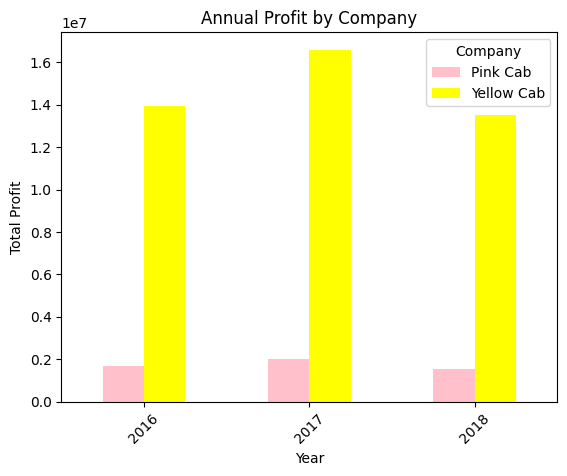

In [7]:
import matplotlib.pyplot as plt

# Load the dataset
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')

# Convert 'Date of Travel' to datetime
final_daily_dataset['Date of Travel'] = pd.to_datetime(final_daily_dataset['Date of Travel'])

# Calculate profit for each transaction
final_daily_dataset['Profit'] = final_daily_dataset['Price Charged'] - final_daily_dataset['Cost of Trip']

# Extract the year from 'Date of Travel'
final_daily_dataset['Year'] = final_daily_dataset['Date of Travel'].dt.year

# Group by year and company and sum profit
annual_profit = final_daily_dataset.groupby(['Year', 'Company'])['Profit'].sum().unstack()

# Create a figure with a white background
fig, ax = plt.subplots(facecolor='white')

# Plot with specific colors
colors = {'Pink Cab': 'pink', 'Yellow Cab': 'yellow'}
annual_profit.plot(kind='bar', color=[colors[name] for name in annual_profit.columns], ax=ax)

# Set the axes background color
ax.set_facecolor('white')

plt.title('Annual Profit by Company')
plt.xlabel('Year')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.legend(title='Company')

# Show the plot with a white background
plt.show()





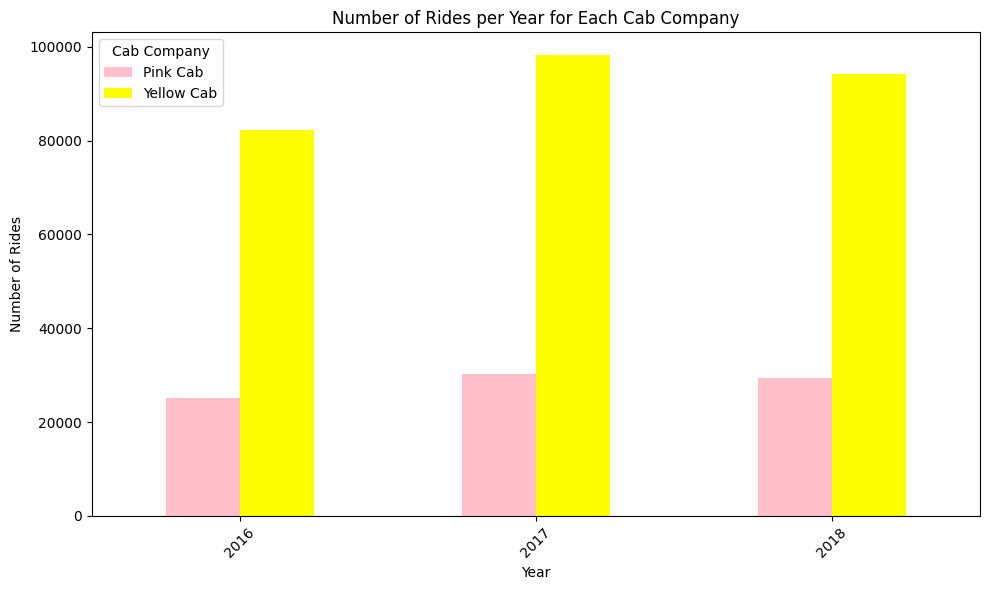

In [6]:


# Load the dataset
df = pd.read_csv('updated_final_daily_dataset.csv')

# Convert the 'Date of Travel' column to datetime
df['Date of Travel'] = pd.to_datetime(df['Date of Travel'])

# Extract the year
df['Year'] = df['Date of Travel'].dt.year

# Calculate the total number of customers per ride
df['Total Customers'] = df['Number of Males'] + df['Number of Females']

# Group by year and company, and sum the total number of customers
rides_per_year_company = df.groupby(['Year', 'Company'])['Total Customers'].sum().unstack()

# Plotting
rides_per_year_company.plot(kind='bar', color = ['pink','yellow'], figsize=(10, 6))
plt.title('Number of Rides per Year for Each Cab Company')
plt.xlabel('Year')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.legend(title='Cab Company')
plt.tight_layout()

plt.show()


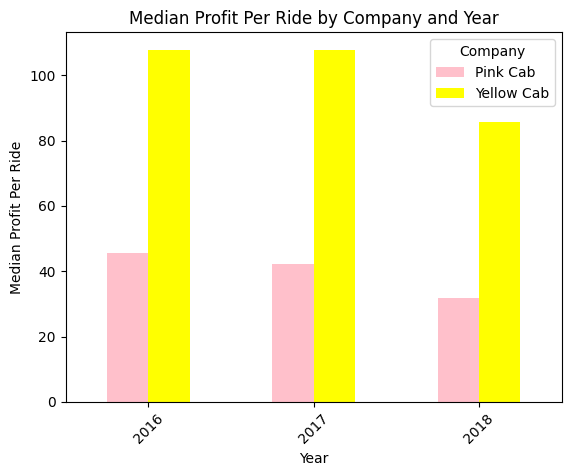

In [8]:


# Assuming your dataset is already loaded and contains the 'Profit' column
# If not, load it and calculate the Profit as before
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')
final_daily_dataset['Date of Travel'] = pd.to_datetime(final_daily_dataset['Date of Travel'])
final_daily_dataset['Profit'] = final_daily_dataset['Price Charged'] - final_daily_dataset['Cost of Trip']
final_daily_dataset['Year'] = final_daily_dataset['Date of Travel'].dt.year

# Calculate the total number of customers per ride
final_daily_dataset['Total Customers'] = final_daily_dataset['Number of Males'] + final_daily_dataset['Number of Females']

# Calculate the profit per ride
final_daily_dataset['Profit Per Ride'] = final_daily_dataset['Profit'] / final_daily_dataset['Total Customers']

# Group by year and company, and calculate the median profit per ride
median_profit_per_ride = final_daily_dataset.groupby(['Year', 'Company'])['Profit Per Ride'].median().unstack()

# Plotting
fig, ax = plt.subplots(facecolor='white')
colors = {'Pink Cab': 'pink', 'Yellow Cab': 'yellow'}
median_profit_per_ride.plot(kind='bar', color=[colors[name] for name in median_profit_per_ride.columns], ax=ax)
ax.set_facecolor('white')

plt.title('Median Profit Per Ride by Company and Year')
plt.xlabel('Year')
plt.ylabel('Median Profit Per Ride')
plt.xticks(rotation=45)
plt.legend(title='Company')

plt.show()


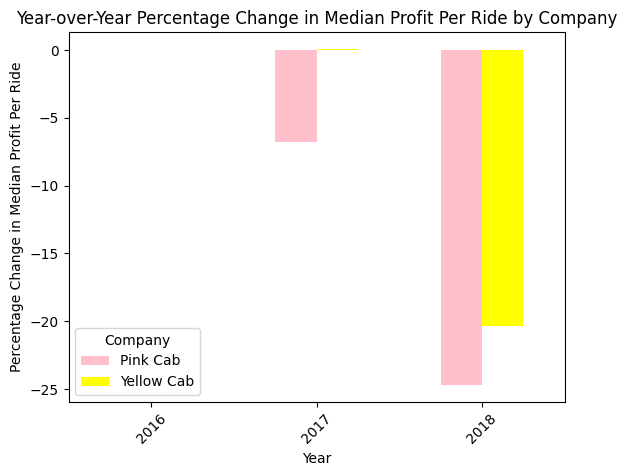

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and calculate necessary columns as previously described
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')
final_daily_dataset['Date of Travel'] = pd.to_datetime(final_daily_dataset['Date of Travel'])
final_daily_dataset['Profit'] = final_daily_dataset['Price Charged'] - final_daily_dataset['Cost of Trip']
final_daily_dataset['Year'] = final_daily_dataset['Date of Travel'].dt.year
final_daily_dataset['Total Customers'] = final_daily_dataset['Number of Males'] + final_daily_dataset['Number of Females']
final_daily_dataset['Profit Per Ride'] = final_daily_dataset['Profit'] / final_daily_dataset['Total Customers']

# Group by year and company, and calculate the median profit per ride
median_profit_per_ride = final_daily_dataset.groupby(['Year', 'Company'])['Profit Per Ride'].median().unstack()

# Calculate year-over-year percentage change in median profit per ride
percent_change_median_profit = median_profit_per_ride.pct_change() * 100

# Plotting
fig, ax = plt.subplots(facecolor='white')
colors = {'Pink Cab': 'pink', 'Yellow Cab': 'yellow'}
percent_change_median_profit.plot(kind='bar', color=[colors[name] for name in percent_change_median_profit.columns], ax=ax)
ax.set_facecolor('white')

plt.title('Year-over-Year Percentage Change in Median Profit Per Ride by Company')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Median Profit Per Ride')
plt.xticks(rotation=45)
plt.legend(title='Company')

plt.show()


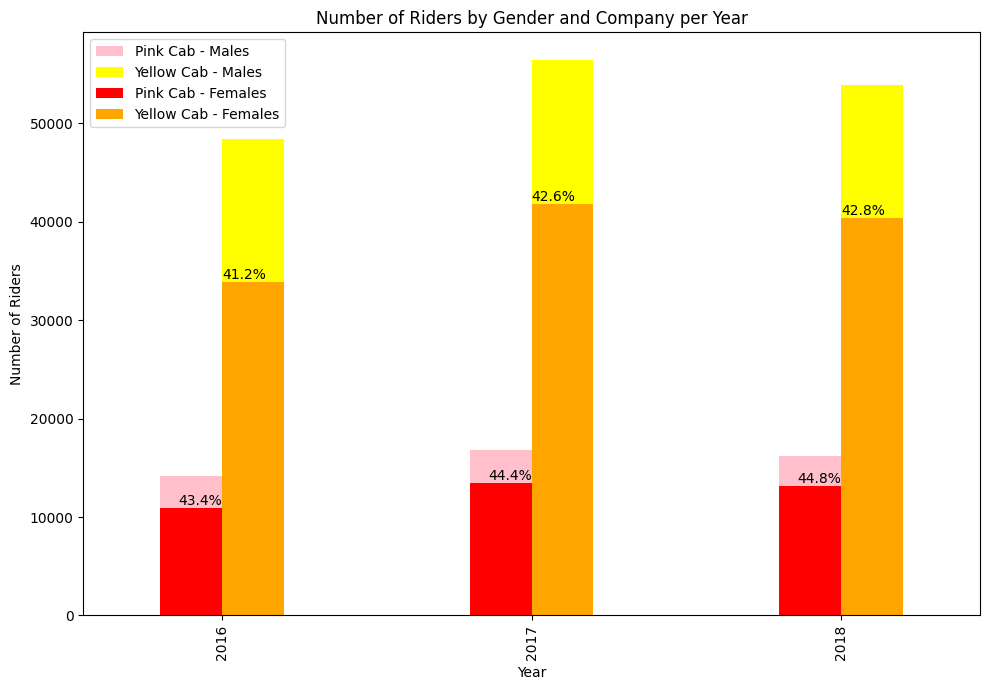

In [89]:

# Load the dataset
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')

# Convert 'Date of Travel' to datetime and extract the year
final_daily_dataset['Date of Travel'] = pd.to_datetime(final_daily_dataset['Date of Travel'])
final_daily_dataset['Year'] = final_daily_dataset['Date of Travel'].dt.year

# Group by 'Year' and 'Company' and sum the number of males and females
gender_distribution = final_daily_dataset.groupby(['Year', 'Company']).agg({
    'Number of Males': 'sum',
    'Number of Females': 'sum'
}).reset_index()

# Calculate the total number of riders and the percentage of female riders
gender_distribution['Total Riders'] = gender_distribution['Number of Males'] + gender_distribution['Number of Females']
gender_distribution['Percent Female'] = gender_distribution['Number of Females'] / gender_distribution['Total Riders']

# Pivot the table to have companies as columns and years as rows
pivot_df = gender_distribution.pivot(index='Year', columns='Company', values=['Number of Males', 'Number of Females', 'Percent Female'])

# Plot the results
fig, ax = plt.subplots(figsize=(10, 7))

# Plotting male and female riders
pivot_df['Number of Males'].plot(kind='bar', ax=ax, position=0.5, width=0.4, color=['pink', 'yellow'])
pivot_df['Number of Females'].plot(kind='bar', ax=ax, position=0.5, width=0.4, color=['red', 'orange'])

# Annotate the percentage of female riders on the bars
for i in range(len(pivot_df)):
    ax.text(i, pivot_df['Number of Females'].iloc[i]['Pink Cab'], f"{pivot_df['Percent Female'].iloc[i]['Pink Cab']:.1%}", ha='right', va='bottom')
    ax.text(i, pivot_df['Number of Females'].iloc[i]['Yellow Cab'], f"{pivot_df['Percent Female'].iloc[i]['Yellow Cab']:.1%}", ha='left', va='bottom')

# Set the labels and title
ax.set_ylabel('Number of Riders')
ax.set_xlabel('Year')
ax.set_title('Number of Riders by Gender and Company per Year')

# Place the legend
ax.legend(['Pink Cab - Males', 'Yellow Cab - Males', 'Pink Cab - Females', 'Yellow Cab - Females'])

# Show the plot
plt.tight_layout()
plt.show()



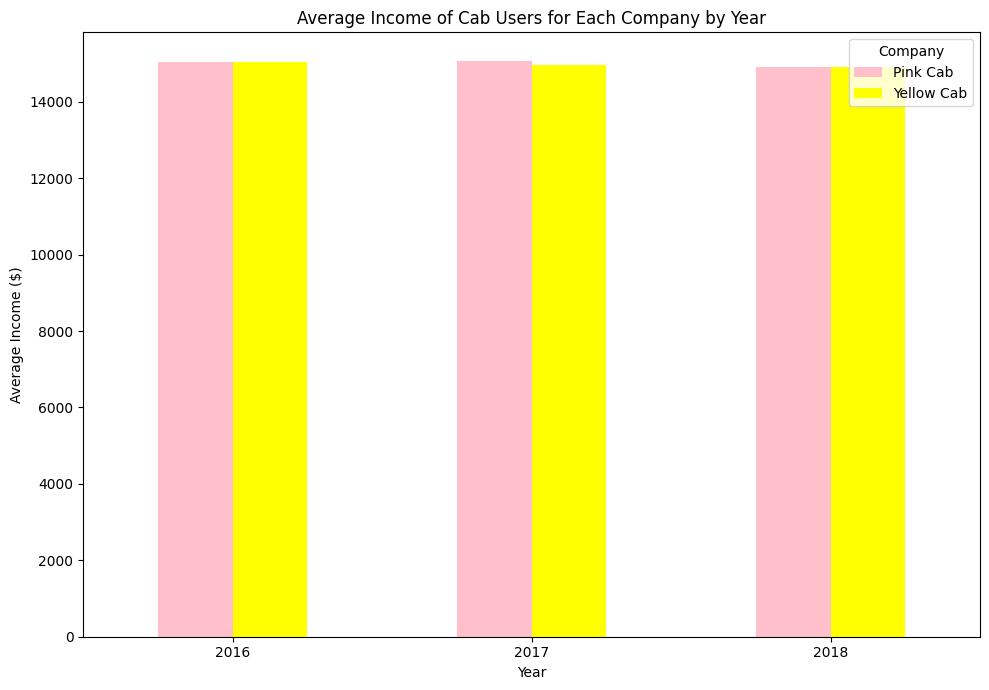

In [90]:
# Average income of the costumers

# Load the dataset from local directory
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')  # Make sure to provide the correct path

# Convert 'Date of Travel' to datetime and extract the year
final_daily_dataset['Date of Travel'] = pd.to_datetime(final_daily_dataset['Date of Travel'])
final_daily_dataset['Year'] = final_daily_dataset['Date of Travel'].dt.year

# Group by 'Year' and 'Company' and calculate the average income
average_income_by_company_year = final_daily_dataset.groupby(['Year', 'Company'])['Average Income'].mean().unstack()

# Define the colors
colors = ['pink', 'yellow'] 

# Plot the results with the specified colors
average_income_by_company_year.plot(kind='bar', figsize=(10, 7), color=colors)
plt.title('Average Income of Cab Users for Each Company by Year')
plt.xlabel('Year')
plt.ylabel('Average Income ($)')
plt.xticks(rotation=0)
plt.legend(title='Company')
plt.tight_layout()
plt.show()



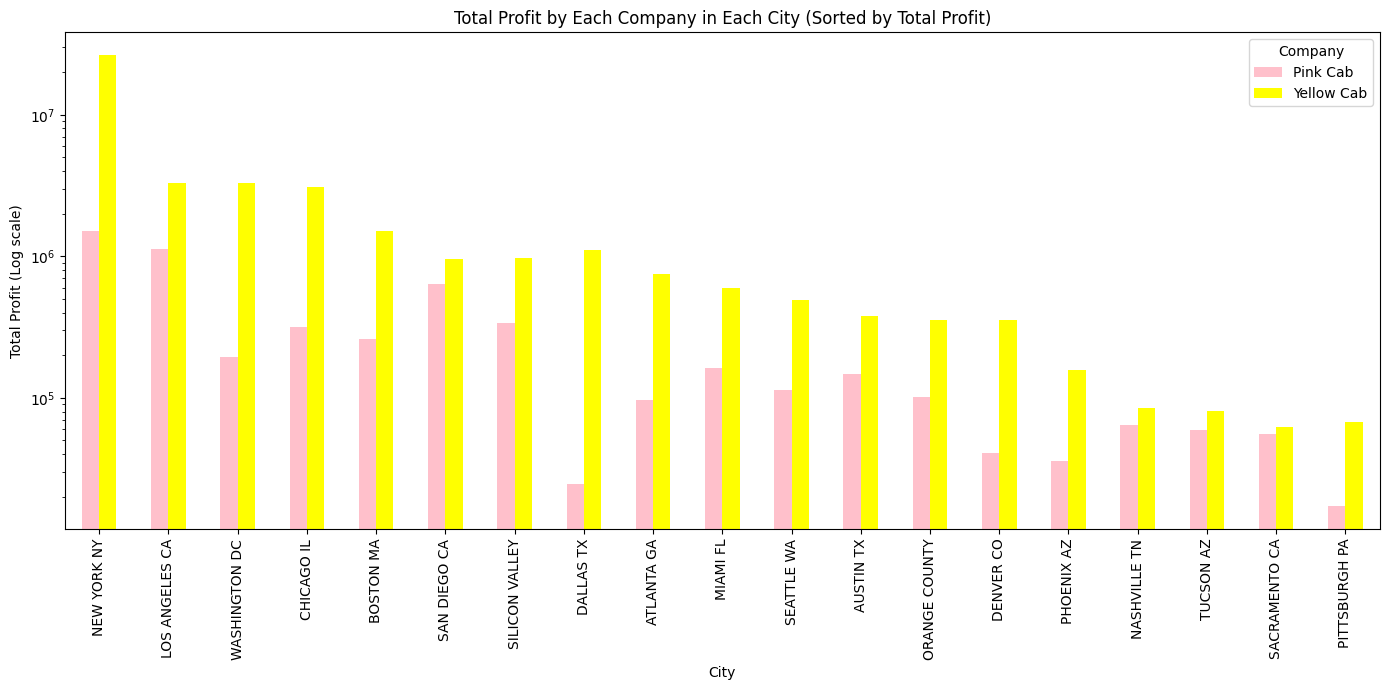

In [91]:
# Profit per city
# Market Trend Hypotheses:
# The growth of the cab industry is directly proportional to urban population growth. As cities grow, so does the demand for cab services.

import matplotlib.pyplot as plt

# Load the dataset
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')  # Make sure to provide the correct path

# Calculate the profit for each trip
final_daily_dataset['Profit'] = final_daily_dataset['Price Charged'] - final_daily_dataset['Cost of Trip']

# Group by 'City' and 'Company' and sum up the profit
city_profit_comparison = final_daily_dataset.groupby(['City', 'Company'])['Profit'].sum().unstack()

# Sort the cities by total profit for better comparison
total_profit_by_city = city_profit_comparison.sum(axis=1).sort_values(ascending=False)
city_profit_comparison = city_profit_comparison.reindex(total_profit_by_city.index)

# Define the colors
colors = ['pink', 'yellow'] 

# Plot the results
fig, ax = plt.subplots(figsize=(14, 7))
city_profit_comparison.plot(kind='bar', ax=ax, color=colors)

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

plt.title('Total Profit by Each Company in Each City (Sorted by Total Profit)')
plt.xlabel('City')
plt.ylabel('Total Profit (Log scale)')
plt.xticks(rotation=90)  # Rotate city names for better readability
plt.legend(title='Company')
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()




In [108]:
 # we need to count the number of unique customers for each company on each day. 
# We will use the Cab_Data.csv and Customer_ID.csv to determine which company each 
# transaction belongs to and then aggregate the data on a daily basis.


import pandas as pd
from datetime import datetime

# Load the datasets
cab_data = pd.read_csv('DataSet/Cab_Data.csv')
transaction_data = pd.read_csv('DataSet/Transaction_ID.csv')
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')

# Function to convert Excel serial date format to datetime
def xl_serial_to_datetime(xl_serial):
    excel_anchor = datetime(1900, 1, 1)
    delta = pd.to_timedelta(xl_serial - 2, unit='D')
    return excel_anchor + delta

# Convert 'Date of Travel' in cab_data
cab_data['Date of Travel'] = cab_data['Date of Travel'].apply(xl_serial_to_datetime)

# Convert 'Date of Travel' to datetime in final_daily_dataset, if it's not already
if final_daily_dataset['Date of Travel'].dtype != 'datetime64[ns]':
    final_daily_dataset['Date of Travel'] = pd.to_datetime(final_daily_dataset['Date of Travel'])

# Merge cab_data with transaction_data
merged_data = pd.merge(cab_data, transaction_data, on='Transaction ID')

# Group by 'Date of Travel' and 'Company' and count unique 'Customer ID'
daily_users = merged_data.groupby(['Date of Travel', 'Company'])['Customer ID'].nunique().reset_index()
daily_users.rename(columns={'Customer ID': 'Daily Users'}, inplace=True)

# Merge the daily users data with the final daily dataset
merged_final_dataset = pd.merge(final_daily_dataset, daily_users, on=['Date of Travel', 'Company'], how='left')

# Save the updated dataset
merged_final_dataset.to_csv('updated_final_daily_dataset.csv', index=False)




In [110]:
# calculate the number of individual users for each city for the whole dataset for each company

import pandas as pd

# Load the datasets
cab_data = pd.read_csv('DataSet/Cab_Data.csv')
transaction_data = pd.read_csv('DataSet/Transaction_ID.csv')
final_daily_dataset = pd.read_csv('updated_final_daily_dataset.csv')

# Merge cab_data with transaction_data
merged_data = pd.merge(cab_data, transaction_data, on='Transaction ID')

# Group by 'City' and 'Company' and count unique 'Customer ID'
individual_users = merged_data.groupby(['City', 'Company'])['Customer ID'].nunique().reset_index()
individual_users.rename(columns={'Customer ID': 'Individual Users'}, inplace=True)

# Merge the individual users data with the final daily dataset
# Ensure that 'City' and 'Company' columns are in the same format in both datasets
merged_final_dataset = pd.merge(final_daily_dataset, individual_users, on=['City', 'Company'], how='left')

# Save the updated dataset
merged_final_dataset.to_csv('updated_final_daily_dataset.csv', index=False)


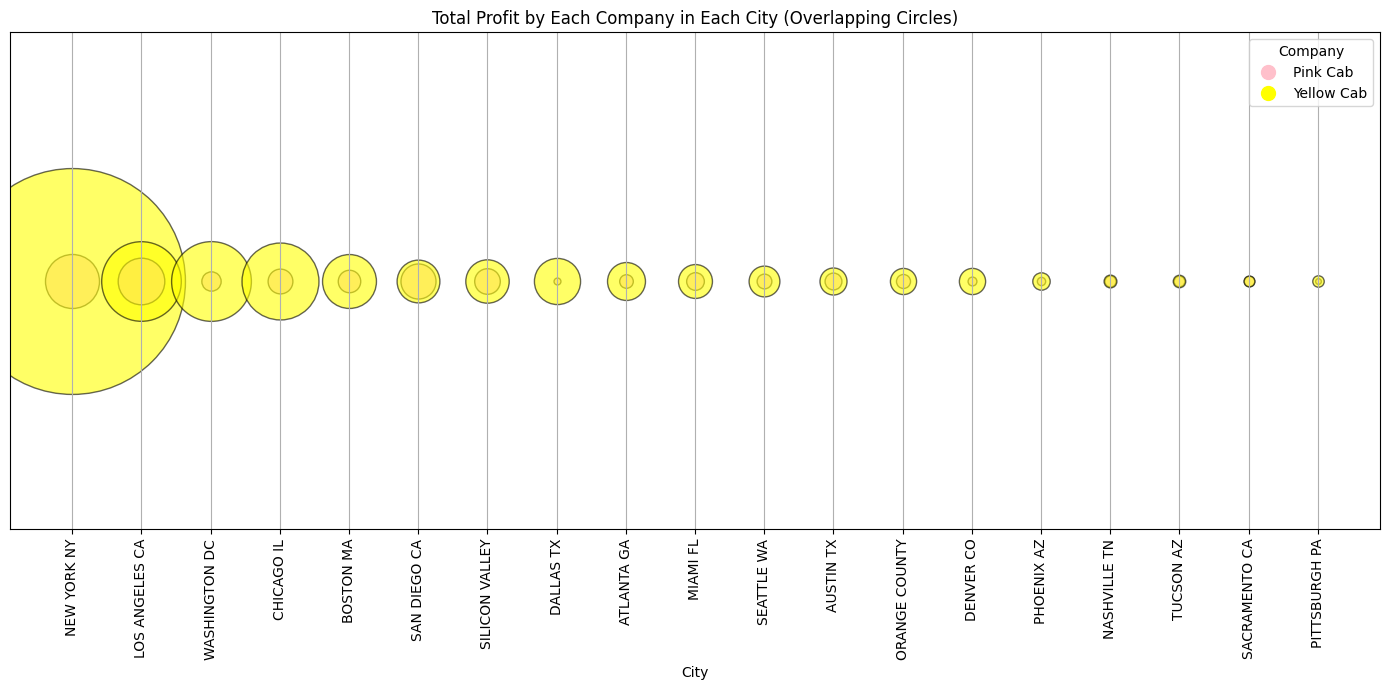

In [112]:
import matplotlib.lines as mlines


# Load the dataset
final_daily_dataset = pd.read_csv('final_daily_dataset.csv')  # Replace with  file path

# Calculate the profit for each trip
final_daily_dataset['Profit'] = final_daily_dataset['Price Charged'] - final_daily_dataset['Cost of Trip']

# Group by 'City' and 'Company' and sum up the profit
city_profit_comparison = final_daily_dataset.groupby(['City', 'Company'])['Profit'].sum().unstack()

# Sort the cities by total profit for better comparison
total_profit_by_city = city_profit_comparison.sum(axis=1).sort_values(ascending=False)
city_profit_comparison = city_profit_comparison.reindex(total_profit_by_city.index)

# Plotting as overlapping circles
fig, ax = plt.subplots(figsize=(14, 7))

# Define colors for each company
colors = {'Pink Cab': 'pink', 'Yellow Cab': 'yellow'}

# Enumerate over cities and companies to plot overlapping circles
for i, city in enumerate(city_profit_comparison.index):
    for j, company in enumerate(city_profit_comparison.columns):
        profit = city_profit_comparison.at[city, company]
        ax.scatter(i, 0, s=profit/1000, color=colors[company], alpha=0.6, edgecolor='black')

# Adjust the aesthetics of the plot
plt.xticks(ticks=range(len(city_profit_comparison.index)), labels=city_profit_comparison.index, rotation=90)
plt.yticks([])
plt.title('Total Profit by Each Company in Each City (Overlapping Circles)')
plt.xlabel('City')
plt.ylabel('')
plt.grid(True)
# Create custom legend handles
legend_handles = [
    mlines.Line2D([], [], color='pink', marker='o', linestyle='None',
                  markersize=10, label='Pink Cab'),
    mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                  markersize=10, label='Yellow Cab')
]
# Use these custom handles in the legend
plt.legend(handles=legend_handles, title='Company')
plt.tight_layout()

# Show the plot
plt.show()

In [113]:
# Customer Behavior Hypotheses:

# Customers are more likely to use cabs during weekends or non-standard 
# work hours when public transportation is less frequent or unavailable

from datetime import datetime
import holidays

# Load  existing dataset (final_daily_dataset.csv)
final_dataset = pd.read_csv('final_daily_dataset.csv')

# Convert 'Date of Travel' to datetime format
final_dataset['Date of Travel'] = pd.to_datetime(final_dataset['Date of Travel'])

# Create a new column 'Weekend' to categorize days as weekends (1) or weekdays (0)
final_dataset['Weekend'] = final_dataset['Date of Travel'].dt.dayofweek // 5  # 1 for Saturday and Sunday, 0 for weekdays

# Define the US holiday calendar
us_holidays = holidays.US(years=final_dataset['Date of Travel'].dt.year.unique())

# Create a new column 'Holiday' to mark holiday days
final_dataset['Holiday'] = final_dataset['Date of Travel'].apply(lambda x: 1 if x in us_holidays else 0)

# Create a new column 'Working_day' to categorize days as working (1) or non-working (0)
final_dataset['Working_day'] = 1  # Initialize with 1
final_dataset.loc[(final_dataset['Weekend'] == 1) | (final_dataset['Holiday'] == 1), 'Working_day'] = 0  # Set to 0 for weekends and holidays

# Save the updated dataset to 'updated_final_daily_dataset.csv'
final_dataset.to_csv('updated_final_daily_dataset.csv', index=False)


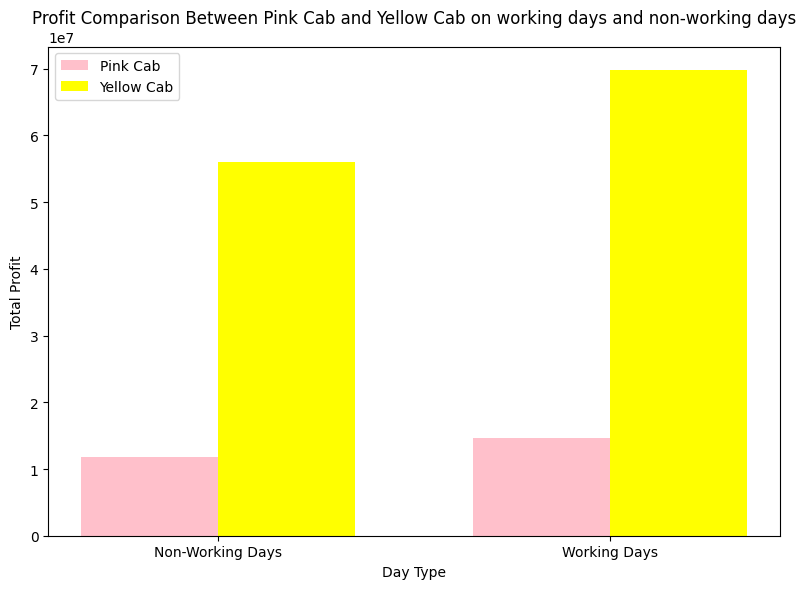

In [116]:

# Load the updated_final_daily_dataset.csv
data = pd.read_csv('updated_final_daily_dataset.csv')

# Filter the data for Pink Cab and Yellow Cab separately
pink_cab_data = data[data['Company'] == 'Pink Cab']
yellow_cab_data = data[data['Company'] == 'Yellow Cab']

# Group the data by 'Working_day' and calculate the total profit for each company
pink_cab_profit = pink_cab_data.groupby('Working_day')['Price Charged'].sum()
yellow_cab_profit = yellow_cab_data.groupby('Working_day')['Price Charged'].sum()

# Create a bar graph to compare profits for Pink Cab and Yellow Cab on workdays and non-working days
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
x = ['Non-Working Days', 'Working Days']
x_indices = range(len(x))
# Define the colors
colors = ['pink', 'yellow'] 
# Plot Pink Cab and Yellow Cab profits side by side
ax.bar([i - width/2 for i in x_indices], pink_cab_profit, width, label='Pink Cab', color='pink')
ax.bar([i + width/2 for i in x_indices], yellow_cab_profit, width, label='Yellow Cab', color='yellow')



# Add labels and legend
ax.set_xlabel('Day Type')
ax.set_ylabel('Total Profit')
ax.set_title('Profit Comparison Between Pink Cab and Yellow Cab on working days and non-working days')
ax.set_xticks(x_indices)
ax.set_xticklabels(x)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


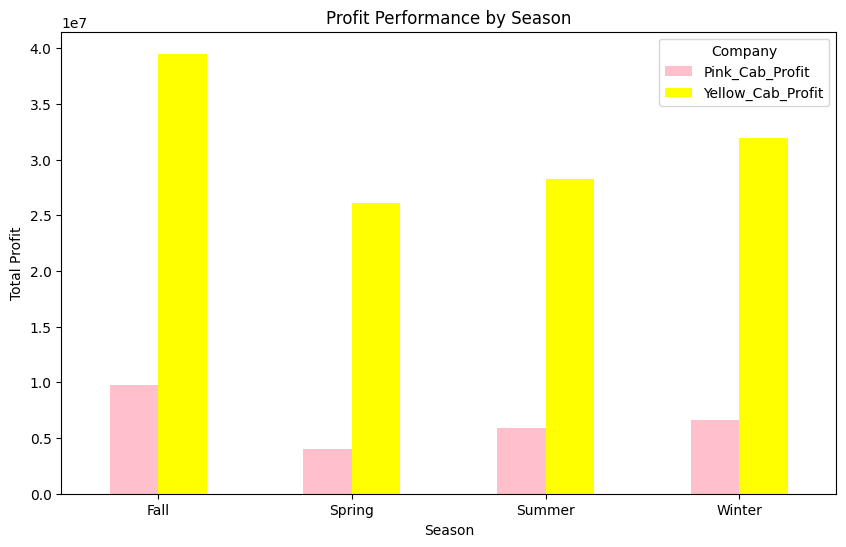

In [122]:
# Customer Behavior Hypotheses:
# Hypo: Customers are more likely to use cabs during weekends or non-standard work hours when public transportation is less frequent or unavailable.

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('updated_final_daily_dataset.csv')

# Extract the month from the 'Date of Travel' column
data['Date of Travel'] = pd.to_datetime(data['Date of Travel'])
data['Year'] = data['Date of Travel'].dt.year
data['Month'] = data['Date of Travel'].dt.month

# Group the data by company, year, and month and calculate the total profit
profit_performance = data.groupby(['Company', 'Year', 'Month'])['Price Charged'].sum().reset_index()

# Pivot the data to have companies as columns and months as rows
pivot_profit_performance = profit_performance.pivot(index=['Year', 'Month'], columns='Company', values='Price Charged').reset_index()

# Rename the columns for clarity
pivot_profit_performance.rename(columns={'Pink Cab': 'Pink_Cab_Profit', 'Yellow Cab': 'Yellow_Cab_Profit'}, inplace=True)

# Define the seasons based on months
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a new column 'Season' based on the month
pivot_profit_performance['Season'] = pivot_profit_performance['Month'].apply(
    lambda month: next(season for season, months in seasons.items() if month in months)
)

# Group the data by season and calculate the profit for each company
seasonly_profit = pivot_profit_performance.groupby(['Season'])[['Pink_Cab_Profit', 'Yellow_Cab_Profit']].sum()

# Plot the graph
seasonly_profit.plot(kind='bar', figsize=(10, 6),  color = ["pink", "yellow"])
plt.title('Profit Performance by Season')
plt.xlabel('Season')
plt.ylabel('Total Profit')
plt.xticks(rotation=0)
plt.legend(title='Company')
plt.show()


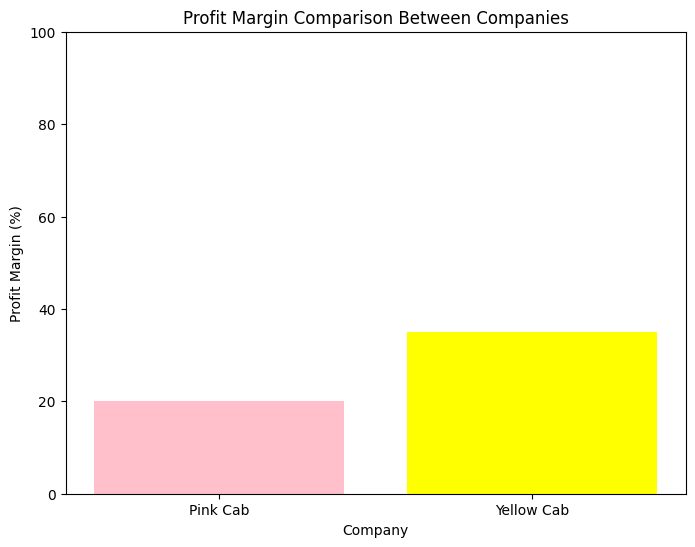

In [124]:
# Company Performance Hypotheses:
# hypo: User
# I want to evaluate this:
# Profit margin: This is calculated as the difference between the revenue and the cost of goods sold (COGS) divided by the revenue, often expressed as a percentage. It indicates what percentage of the revenue constitutes profit.


import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('updated_final_daily_dataset.csv')

# Calculate the profit for each transaction
data['Profit'] = data['Price Charged'] - data['Cost of Trip']

# Group the data by company and calculate the total revenue, total cost, and total profit
company_profit = data.groupby('Company').agg({
    'Price Charged': 'sum',
    'Cost of Trip': 'sum',
    'Profit': 'sum'
})

# Calculate the profit margin as a percentage
company_profit['Profit Margin (%)'] = (company_profit['Profit'] / company_profit['Price Charged']) * 100

# Reset index for plotting
company_profit.reset_index(inplace=True)

# Plot the profit margin comparison
plt.figure(figsize=(8, 6))
plt.bar(company_profit['Company'], company_profit['Profit Margin (%)'],  color = ["pink", "yellow"])
plt.title('Profit Margin Comparison Between Companies')
plt.xlabel('Company')
plt.ylabel('Profit Margin (%)')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100%
plt.show()


Results of Dickey-Fuller Test for Pink Cab:
Test Statistic                 -3.560466
p-value                         0.006563
#Lags Used                      6.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
Results of Dickey-Fuller Test for Pink Cab:
Test Statistic                -7.893108e+00
p-value                        4.382675e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+01
Critical Value (1%)           -3.737709e+00
Critical Value (5%)           -2.992216e+00
Critical Value (10%)          -2.635747e+00
dtype: float64
                                     SARIMAX Results                                     
Dep. Variable:                     Price Charged   No. Observations:                   28
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 2)   Log Likelihood                -298.166
Date:            

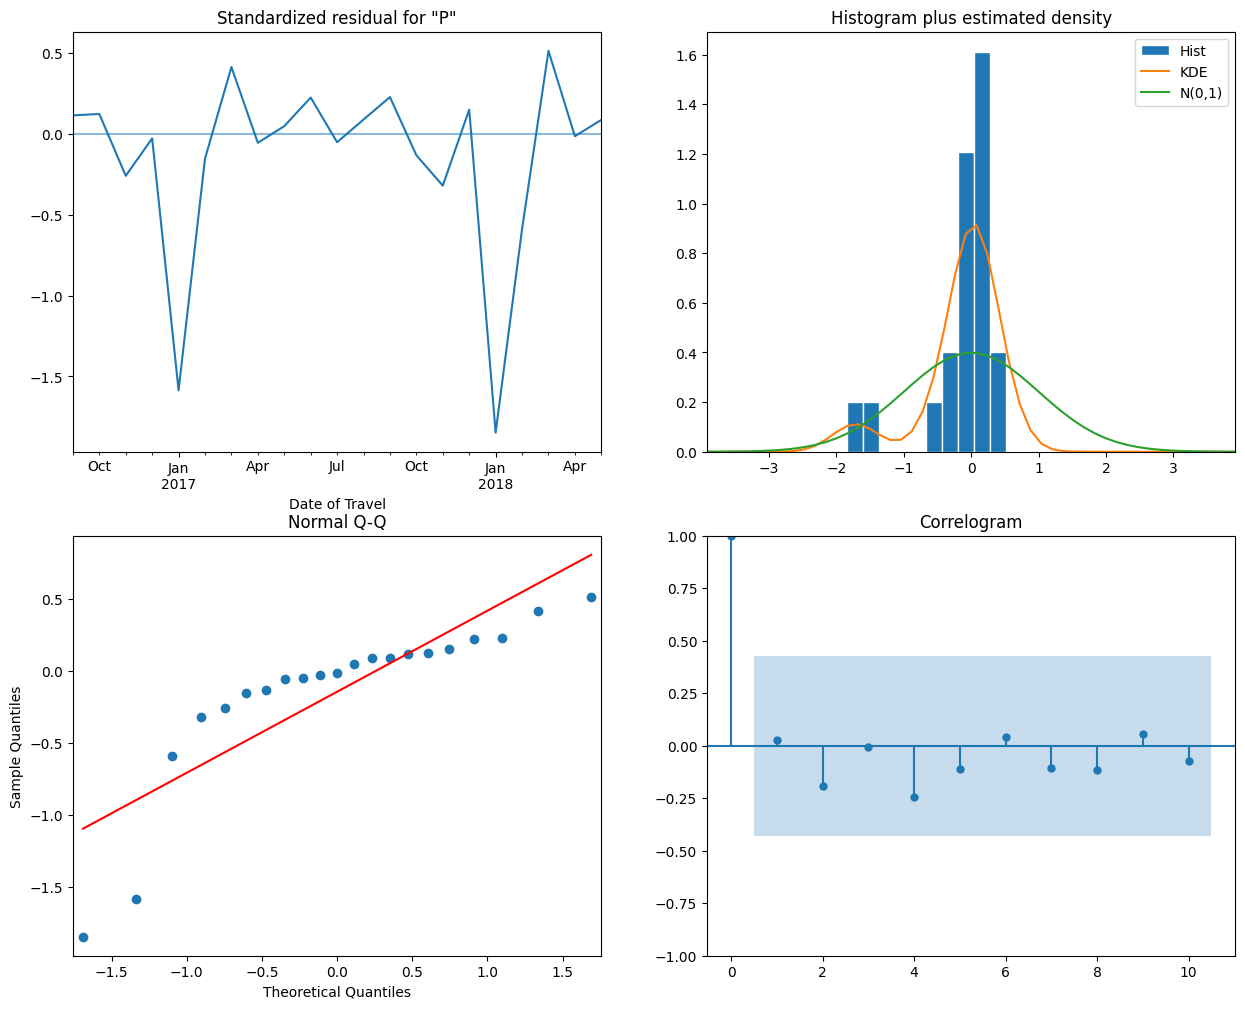

Mean Squared Error (MSE) for Pink Cab: 8409583782.70


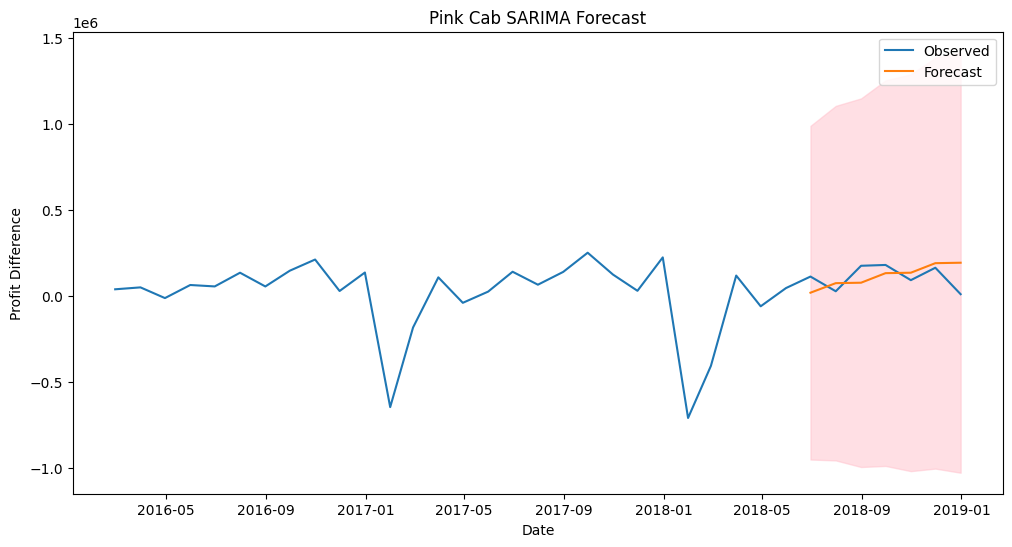

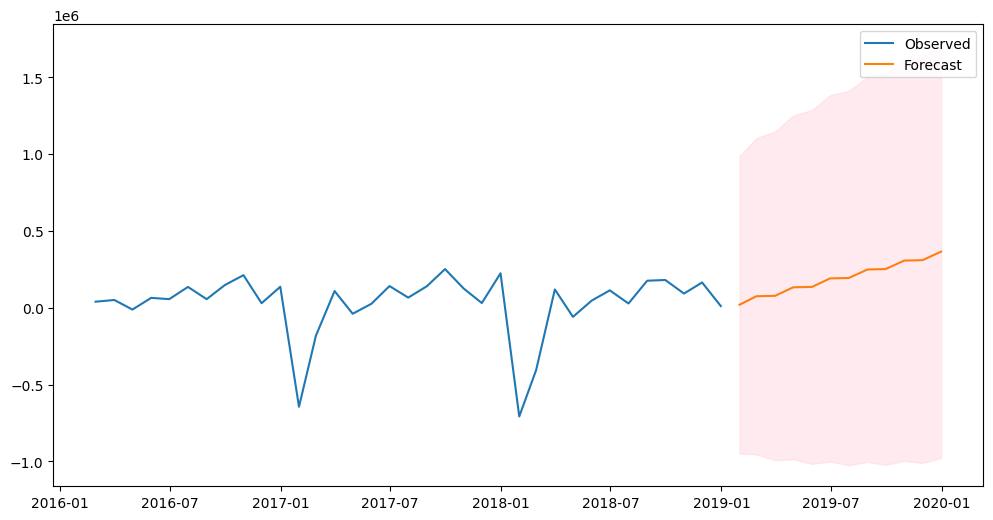

Results of Dickey-Fuller Test for Yellow Cab:
Test Statistic                 -1.977609
p-value                         0.296476
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
Results of Dickey-Fuller Test for Yellow Cab:
Test Statistic                 -5.364644
p-value                         0.000004
#Lags Used                      9.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
                                     SARIMAX Results                                     
Dep. Variable:                     Price Charged   No. Observations:                   28
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 2)   Log Likelihood                -322.491
Date:                           Sa

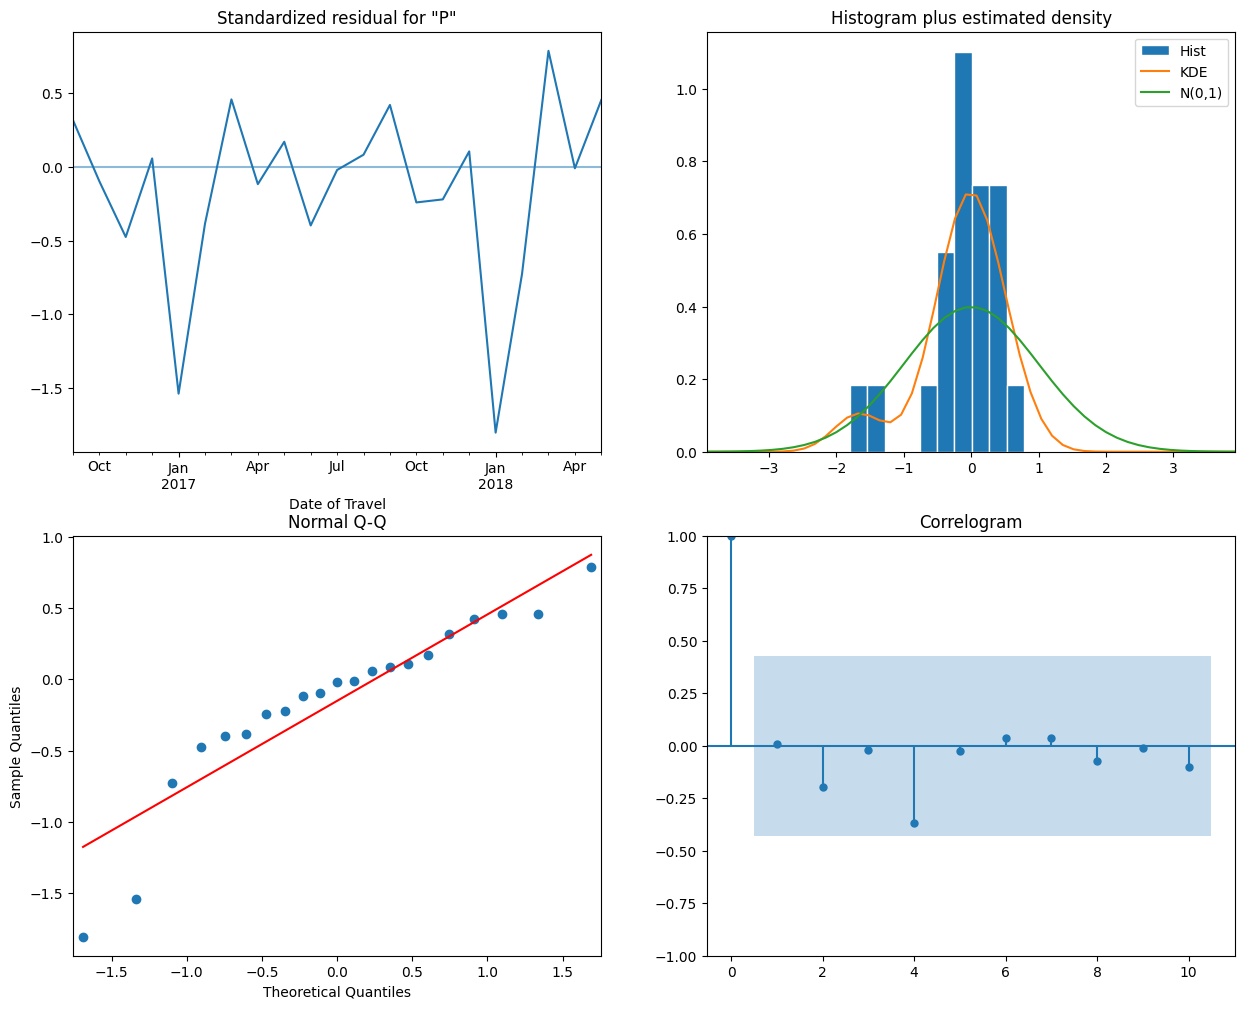

Mean Squared Error (MSE) for Yellow Cab: 63479490342.80


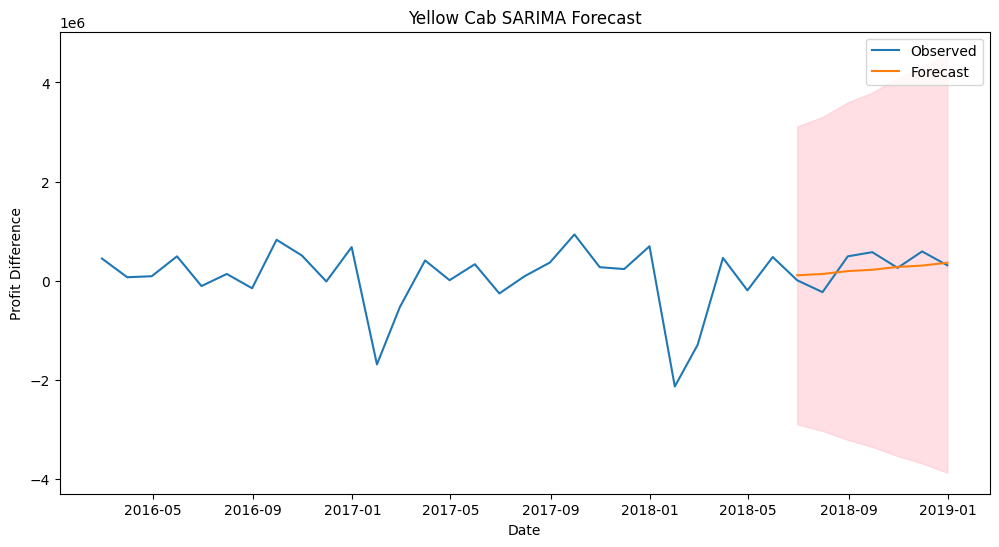

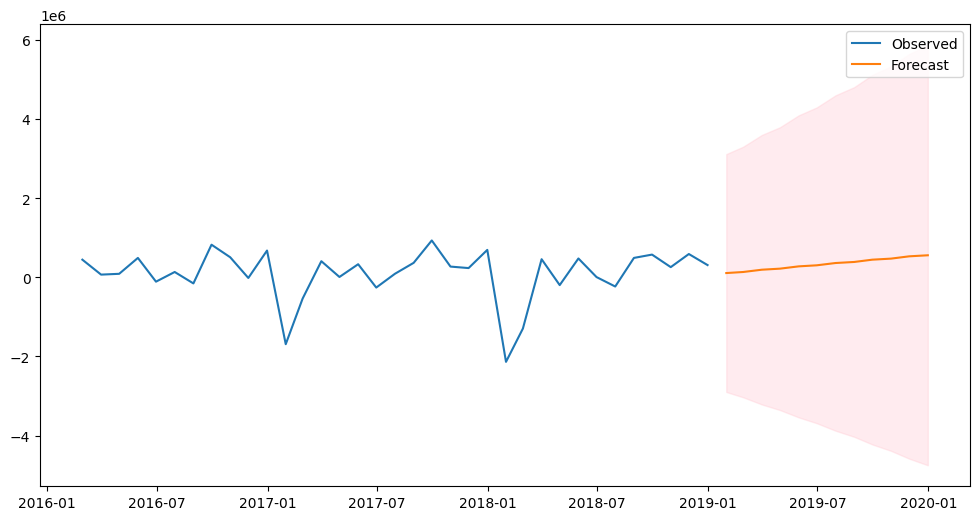

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('updated_final_daily_dataset.csv')

# Convert the 'Date of Travel' column to datetime
data['Date of Travel'] = pd.to_datetime(data['Date of Travel'])

# List of companies
companies = ['Pink Cab', 'Yellow Cab']

# Function to test stationarity
def test_stationarity(timeseries, company_name):
    # Perform Dickey-Fuller test
    print(f'Results of Dickey-Fuller Test for {company_name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Loop through each company
for chosen_company in companies:
    # Extract profit data for the chosen company
    profit_data = data[data['Company'] == chosen_company]

    # Extract the 'Date of Travel' and 'Price Charged' columns for modeling
    profit_data = profit_data[['Date of Travel', 'Price Charged']]

    # Set 'Date of Travel' as the index
    profit_data.set_index('Date of Travel', inplace=True)

    # Resample the data to monthly frequency and sum the profits for each month
    profit_data_monthly = profit_data.resample('M').sum()

    # Check stationarity
    test_stationarity(profit_data_monthly['Price Charged'], chosen_company)

    # Differencing to achieve stationarity if necessary
    profit_data_monthly_diff = profit_data_monthly.diff().dropna()

    # Check stationarity after differencing
    test_stationarity(profit_data_monthly_diff['Price Charged'], chosen_company)

    # Split the data into training and testing sets
    train_size = int(len(profit_data_monthly_diff) * 0.8)
    train, test = profit_data_monthly_diff[:train_size], profit_data_monthly_diff[train_size:]

    # Build and train the SARIMA model
    p, d, q = 0, 1, 1  # Non-seasonal parameters
    P, D, Q, s = 0, 1, 1, 2  # Seasonal parameters - assuming monthly data with yearly seasonality

    sarima_model = SARIMAX(train, 
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)

    sarima_result = sarima_model.fit()

    # Summary of the model
    print(sarima_result.summary())

    # Model diagnostics
    sarima_result.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # Forecasting
    n_periods = len(test)  # Number of periods to forecast should match the test set size
    forecast = sarima_result.get_forecast(steps=n_periods)
    forecast_index = pd.date_range(profit_data_monthly_diff.index[train_size], periods=n_periods, freq='M')

    # Get forecast and confidence intervals
    forecast_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    # Calculate the Mean Squared Error (MSE) for the forecast
    mse = mean_squared_error(test, forecast_mean)
    print(f'Mean Squared Error (MSE) for {chosen_company}: {mse:.2f}')

    # Plotting the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(profit_data_monthly_diff.index, profit_data_monthly_diff, label='Observed')
    plt.plot(forecast_index, forecast_mean, label='Forecast')
    plt.fill_between(forecast_index,
                     confidence_intervals.iloc[:, 0],
                     confidence_intervals.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f'{chosen_company} SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Profit Difference')
    plt.legend()
    plt.show()
    
    # Define the number of steps to forecast beyond the dataset
    n_forecast_steps = 12  # for example, if you want to forecast one year ahead monthly
    
    # The last date in  observed data
    last_observation = profit_data_monthly_diff.index[-1]
    
    # Generate date range for forecasts starting after the last observed date
    forecast_dates = pd.date_range(start=last_observation, periods=n_forecast_steps + 1, freq='M')[1:]
    
    # Get the forecast for the specified number of steps beyond the dataset
    forecast = sarima_result.get_forecast(steps=n_forecast_steps)
    forecast_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    # Plotting the observed and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(profit_data_monthly_diff.index, profit_data_monthly_diff, label='Observed')
    plt.plot(forecast_dates, forecast_mean, label='Forecast')
    plt.fill_between(forecast_dates,
                     confidence_intervals.iloc[:, 0],
                     confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.show()
